# Post-Hoc Analysis: Get Overview Examples, Error analysis, LLM (?)...


In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import tikzplotlib
import joblib
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import (accuracy_score, classification_report,
                            confusion_matrix, ConfusionMatrixDisplay,
                            roc_auc_score)

from sklearn.svm import SVC
from time import time
import os
os.chdir("GDELT_GKG")

import warnings
warnings.filterwarnings('ignore')

In [2]:
# data
dataset_extension = "_mbfc_allbias_extrafeatures"

test = pd.read_csv("data/test{}.csv".format(dataset_extension))
test.set_index("outlet", inplace=True)

X_test = test.drop("lean", axis=1)
y_test = test["lean"]


## Get Best (NN) Model for inference

In [3]:
import torch
import torch.nn as nn
import torch.optim as torch_optim
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader,Dataset
from torchmetrics import Accuracy

#### Get relevant classes

In [4]:
class OutletBiasDataset(Dataset):
    """
    Dataset class for PyTorch's, allowing us to work with the csv dataset.
    
    From the docs:
    All datasets that represent a map from keys to data samples should subclass it. 
    All subclasses should overwrite __getitem__(), supporting fetching a data sample 
    for a given key. Subclasses could also optionally overwrite __len__(), which is 
    expected to return the size of the dataset by many Sampler implementations and 
    the default options of DataLoader.
    
    """
    def __init__(self, data, numer_cols, categ_cols, label_col):
        data = data.copy()
        #numerical columns
        self.X_num = data.loc[:,numer_cols].copy().values.astype(np.float32)
        #categorical columns
        self.X_cat = data.loc[:,categ_cols].copy().values.astype(np.int64)
        self.y = data[label_col]
        self.index = data.index

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.index[idx], self.X_num[idx], self.X_cat[idx], self.y[idx]


class TabularDataModule(pl.LightningDataModule):
    """
    The Pytorch DataModule enables reusing classes, while incorporating
    all preprocessing steps: making datasets into OutletBiasDataset class instances.
    The DataLoaders are also made here, as required by PyTorch and PyTorch Lightning
    """

    def __init__(self, datadir, dataset_extension,
                 num_cols, cat_cols, label_col, num_workers=0,
                 batch_size_train=16, batch_size_val=16, batch_size_test=16):
        
        super().__init__()
        #os.chdir(datadir)
        # datasets
        self.train = pd.read_csv("{}/train{}.csv".format(datadir, dataset_extension))
        self.train.set_index("outlet", inplace=True)
        
        self.val = pd.read_csv("{}/val{}.csv".format(datadir, dataset_extension))
        self.val.set_index("outlet", inplace=True)
        
        self.test = pd.read_csv("{}/test{}.csv".format(datadir, dataset_extension))
        self.test.set_index("outlet", inplace=True)
        
        self.full = pd.concat([self.train,self.val,self.test])
        
        # define other variables
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.label_col = label_col
        self.num_workers = num_workers
        self.batch_size_train = batch_size_train
        self.batch_size_val = batch_size_val
        self.batch_size_test = batch_size_test

    def setup(self, stage=""):
        # check dataset shapes
        print('Train set shape: ', self.train.shape)
        print('Validation set shape: ', self.val.shape)
        print('Test set shape: ', self.test.shape)
        
        # MAKE INTO DATASET FORMAT
        self.dataset_train = OutletBiasDataset(self.train,
                                               self.num_cols,self.cat_cols, self.label_col)
        self.dataset_val = OutletBiasDataset(self.val,
                                               self.num_cols,self.cat_cols, self.label_col)
        self.dataset_test = OutletBiasDataset(self.test,
                                               self.num_cols,self.cat_cols, self.label_col)
        self.dataset_full = OutletBiasDataset(self.full,
                                       self.num_cols,self.cat_cols, self.label_col)

    def train_dataloader(self):
        return DataLoader(
            self.dataset_train,
            num_workers=self.num_workers,
            batch_size=self.batch_size_train,
            shuffle=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.dataset_val,
            num_workers=self.num_workers,
            batch_size=self.batch_size_val,
            shuffle=False
        )

    def test_dataloader(self):
        return DataLoader(
            self.dataset_test,
            num_workers=self.num_workers,
            batch_size=self.batch_size_test,
            shuffle=False
        )
    
    def full_dataloader(self):
        return DataLoader(
            self.dataset_full,
            num_workers=self.num_workers,
            batch_size=self.batch_size_train,
            shuffle=False
        )

class TabularNetModel(pl.LightningModule):
    """
    Model class in PyTorch Lightning. Model structure is defined in self.layers().
    
    Initialize with:
    - num_cols: columns in dataset that are numeric,
    - cat_cols: columns in dataset that are categorical (and thus will be embedded),
    - embedding_size_dict: predetermined embedding sizes per categorical feature,
    - n_classes: number of classes to be classified,
    - learning_rate: model's learning rate,
    - neurons_per_layer_list: list of neurons to be put per layer, for any number of layers,
    - dropout_p: dropout probability between each layer
    
    """
    def __init__(self, num_cols, cat_cols, embedding_size_dict, n_classes,
                 neurons_per_layer_list=[512,256,128],
                 learning_rate=0.001, dropout_p=0.2):
        super().__init__()
        
        # pytorch lightning black magic, all the arguments can now be
        # accessed through self.hparams.[argument]
        self.save_hyperparameters()
        self.num_cols = num_cols
        self.num_len = len(num_cols)
        self.cat_cols = cat_cols
        self.cat_len = len(cat_cols)
        self.n_classes = n_classes
        
        self.embeddings, total_embedding_dim = self._create_embedding_layers(
            cat_cols, embedding_size_dict)
        
        # concatenate the numerical variables and the embedding layers
        # then proceed with the rest of the sequential flow
        in_features = self.num_len + total_embedding_dim
        
        # let's finally define the model architecture itself:
        all_layers = []
        for i in neurons_per_layer_list:
            all_layers.append(nn.Linear(in_features, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(dropout_p))
            in_features = i
            
        # add final output layer,
        all_layers.append(nn.Linear(neurons_per_layer_list[-1], n_classes))
        # and put into Sequantial.
        self.layers = nn.Sequential(*all_layers)
        
        # something to keep track of accuracy with...
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.n_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.n_classes)

    @staticmethod
    def _create_embedding_layers(cat_cols, embedding_size_dict):
        """construct the embedding layer, 1 per each categorical variable"""
        total_embedding_dim = 0 # keep track of the embed dim for input size
        embeddings = {}
        for col in cat_cols:
            # get embedding size and dim ("size" here is the num of classes)
            embedding_size = embedding_size_dict[col][0]
            embedding_dim = embedding_size_dict[col][1] # dim is vector size
            total_embedding_dim += embedding_dim
            # we add 2 to the output size due to some PyTorch shenanigans, see:
            # https://discuss.pytorch.org/t/solved-assertion-srcindex-srcselectdimsize-failed-on-gpu-for-torch-cat/1804/13
            embeddings[col] = nn.Embedding(embedding_size+2, embedding_dim)

        return nn.ModuleDict(embeddings), total_embedding_dim

    def forward(self, num_tensor, cat_tensor):
        # run through all the categorical variables through its
        # own embedding layer and concatenate them together
        cat_outputs = []
        for i, col in enumerate(self.hparams.cat_cols):
            embedding = self.embeddings[col]
            cat_input = cat_tensor[:, i].long() #!
            cat_output = embedding(cat_input)
            cat_outputs.append(cat_output)

        # concatenate to torch tensor with dim=1
        cat_outputs = torch.cat(cat_outputs, dim=1)
        # concatenate the categorical embedding and numerical layer
        all_outputs = torch.cat((num_tensor, cat_outputs), dim=1)
        
        # now we get the final outputs through the layers we made earlier
        final_outputs = self.layers(all_outputs).squeeze(dim=1)
        
        return F.log_softmax(final_outputs, dim=1)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), 
                                lr=self.hparams.learning_rate)
    
    def training_step(self, batch, batch_idx):
        index, num_tensor, cat_tensor, label_tensor = batch
        output_tensor = self(num_tensor, cat_tensor)
        # compute loss
        loss = F.nll_loss(output_tensor, label_tensor)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        index, num_tensor, cat_tensor, label_tensor = batch
        output_tensor = self(num_tensor, cat_tensor)
        # compute loss
        loss = F.nll_loss(output_tensor, label_tensor)
        self.log("val_loss", loss, prog_bar=True)
        # compute accuracy
        preds = torch.argmax(output_tensor, dim=1)
        self.val_accuracy.update(preds, label_tensor)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        print('testing step: ', batch_idx)
        index, num_tensor, cat_tensor, label_tensor = batch
        output_tensor = self(num_tensor, cat_tensor)
        # compute loss
        loss = F.nll_loss(output_tensor, label_tensor)
        self.log('test_loss', loss, prog_bar=True)
        # compute accuracy
        preds = torch.argmax(output_tensor, dim=1)
        self.val_accuracy.update(preds, label_tensor)
        self.log("test_acc", self.val_accuracy, prog_bar=True)


In [5]:
# get evaluation-related code

def predict(tabular_model, tabular_data_module):
    print('predicting...')
    data_loader = tabular_data_module.test_dataloader()
    batch_size = data_loader.batch_size
    n_rows = len(tabular_data_module.dataset_test)
    
    y_true = np.zeros(n_rows, dtype=np.float32)
    y_pred = np.zeros((n_rows,5), dtype=np.float32)
    indexes = []
    with torch.no_grad():
        idx = 0
        for index, num_batch, cat_batch, label_batch in tqdm(data_loader, desc="Evaluating"):
            # get model output
            y_output = tabular_model(num_batch, cat_batch)
            y_prob = y_output.cpu().numpy()
            # map exp function to all outputs
            y_prob = list(map(np.exp,y_prob))

            # add predictions to output arrays
            start_idx = idx
            idx += batch_size
            end_idx = idx
            y_pred[start_idx:end_idx] = y_prob
            y_true[start_idx:end_idx] = label_batch.cpu().numpy()
            
            # append indexes
            indexes.extend(index)

            if end_idx == n_rows:
                break

    return y_true, y_pred, indexes

def get_AUC_scores(y_test,y_pred):
    """
    Since we need to use OneHotEncoded values for AUC, we'll do that here separately.
    We also calculate the AUC per class, and also its average. Then put this in
    array and pad it so it fits into the report DataFrame.
    """
    ohe = OneHotEncoder()
    out = ohe.fit_transform(y_test.values.reshape(-1, 1)).toarray()
    y_test_ohe = pd.DataFrame(out, index=y_test.index)
    # get same shape for predictions - note that preds often arrays, not series, so don't need .values
    out = ohe.transform(y_pred.reshape(-1, 1)).toarray()
    y_pred_ohe = pd.DataFrame(out, index=y_test.index)
    
    # compute actual scores
    AUC_avg = roc_auc_score(y_test_ohe,y_pred_ohe, multi_class='ovr')
    AUC_per_class = roc_auc_score(y_test_ohe,y_pred_ohe, average=None,multi_class='ovr')
    # add AUC to report DF
    AUC_list = np.append(AUC_per_class,AUC_avg)
    AUC_list = np.append(AUC_list, [0,0]) # add padding so it fits into DF
    
    return AUC_list

def evaluate_predictions(y_test,y_pred,save=True,model_name=""):
    """
    Note that y_test and y_pred both have to have 1 dimension only here - no probs per class.
    """
    # make list of class names in correct order
    class_names = ["left","left center","least biased","right center","right"] # in order from MBFC mappings
    # make report of predictions
    report = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True,
                                  target_names=class_names))
    # get AUC score & add to report DF
    report.loc['AUC',:] = get_AUC_scores(y_test,y_pred)
    
    # make confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
            y_test,
            y_pred,
            display_labels = class_names, 
            xticks_rotation="vertical",
            cmap=plt.cm.Blues,
        )
    disp.ax_.set_title("{} Confusion Matrix of Outlet Bias".format("model_name"))
    tikzplotlib.save("{}_Confusion_Matrix_TKZ.tikz".format(model_name))
    # print results and timing
    print("Test accuracy")
    print(f"{accuracy_score(y_test, y_pred):.2%}\n")

    if save == True:
        # save picture and report
        save_path_confmx = "{}_Confusion_Matrix.png".format(model_name)
        save_path_report = "{}_Report.csv".format(model_name)
        # picture
        tikzplotlib.save("{}_Confusion_Matrix_TKZ2.tikz".format(model_name))
        disp.figure_.savefig(save_path_confmx)
        report.to_csv(save_path_report)

    return report,disp

def eval_model(model,model_name="PyTorch",save=False):
    # get true and predicted values (note that y_true here is still prob values per class, not output class)
    y_true, y_pred, indexes = predict(model, tabular_data_module)
    y_argmax_pred = np.argmax(y_pred,axis=1)
    # make y_true nto pd Series with old index intact
    y_test = pd.Series(y_true,index=indexes)
    # evaluate
    report,disp = evaluate_predictions(y_test,y_argmax_pred,save=save,model_name=model_name)
    return report,disp

#### Get Model

In [6]:
#model = torch.load(f'results/Experiment_mbfc_allbias_include_categorical_1505/best_torch_15052023.pt', map_location=torch.device('cpu')) # this one was not the best one
model = torch.load('results/Experiment_mbfc_allbias_extrafeatures/best_torch.pt', map_location=torch.device('cpu'))

# Set evaluation mode
model.eval()

TabularNetModel(
  (embeddings): ModuleDict(
    (Factuality): Embedding(8, 4)
    (PressFreedom): Embedding(6, 3)
    (MediaType): Embedding(9, 5)
    (Traffic): Embedding(5, 3)
    (Credibility): Embedding(5, 3)
  )
  (layers): Sequential(
    (0): Linear(in_features=377, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=256, out_features=5, bias=True)
  )
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
)

#### Get the data
Need to put the data into the dataloader...

In [7]:
class_names = ["left","left center","least biased","right center","right"] #["left","center","right"]# in order from MBFC mappings
dataset_extension = "_mbfc_allbias_extrafeatures"

#------------------------------------------------------------------------------
# GET CATEGORICAL FEATURES TO EMBED AND DETERMINE EMBEDDING SIZES
#------------------------------------------------------------------------------

# we need to make sure we subset the data from which we get the embeddings to 
# the columns present in (in this case) testing set, ignore var name
train_cols = test.columns

# get and subset data (full data, we split into train test in dataloader
data = pd.read_csv("extras/mbfc_outlet_sentiments.csv")
data.set_index("outlet", inplace=True)
data.rename({"Latitude":"Latutude"},axis=1,inplace=True) # wrongly named column, replace
data = data[train_cols]

data.head()

,ACT_YIELD_PosScore,ACT_YIELD_article_count,AID_ECONOMIC_SelfRefDens,AID_ECONOMIC_article_count,ASSASSINATION_SelfRefDens,AVIATION_INCIDENT_article_count,BLACK_MARKET_NegScore,BULLYING_article_count,CEASEFIRE_PosScore,CHARASMATIC_LEADERSHIP_Polarity,...,SOC_EXCEPTIONALISM_article_count,DISCRIMINATION_IMMIGRATION_ULTRANATIONALISTS_SelfRefDens,lean,Factuality,PressFreedom,MediaType,Traffic,Credibility,Longitude,Latutude
outlet,,,,,,,,,,,,,,,,,,,,,
10news.com,0.005368,0.002654,0.002457,0.001180,0.000857,0.008847,0.011758,0.006635,0.004432,0.019324,...,0.0,0.0,2,4,2.0,6,1,2,-100.445882,39.78373
10tv.com,0.004775,0.004836,0.000785,0.002955,0.001177,0.008329,0.011075,0.013434,0.004382,0.020157,...,0.0,0.0,2,4,2.0,7,2,2,-100.445882,39.78373
11alive.com,0.005535,0.003803,0.000839,0.002048,0.001613,0.008192,0.011397,0.010825,0.004188,0.021971,...,0.0,0.0,2,4,2.0,7,1,2,-100.445882,39.78373
12news.com,0.005067,0.003268,0.000599,0.002080,0.001252,0.008616,0.012763,0.008318,0.004107,0.026413,...,0.0,0.0,2,4,2.0,6,1,2,-100.445882,39.78373
12news.com,0.005067,0.003268,0.000599,0.002080,0.001252,0.008616,0.012763,0.008318,0.004107,0.026413,...,0.0,0.0,2,4,2.0,6,1,2,-100.445882,39.78373


In [8]:
# get categorical and numerical columns
label_col = "lean"
cat_cols = ["Factuality","PressFreedom","MediaType","Traffic","Credibility"]
num_cols = data.columns[~data.columns.isin(cat_cols + [label_col])]
feature_cols = data.columns[~data.columns.isin([label_col])]

# for easier processing, let's temporarily set cat column types to "category"
data[cat_cols] = data[cat_cols].astype('category')
# get number of classes per categorical column
classes_per_col = {name: len(col.cat.categories) 
                   for name,col in  data[cat_cols].items()}
# determine embedding sizes: embedding size rule from fastai and: http://ethen8181.github.io/machine-learning/deep_learning/tabular/tabular.html
embedding_sizes = {col_name: (n_categories, 
                              min(600, round(1.6 * n_categories ** 0.56))
                             )
                   for col_name,n_categories in classes_per_col.items()}

In [9]:
# MAKE DATASET MODULE
tabular_data_module = TabularDataModule("data", 
                                        dataset_extension=dataset_extension,
                                        num_cols=num_cols, cat_cols=cat_cols, label_col=label_col, 
                                        num_workers=0, # num workers has to be 0 else synchronization process got weird
                                        batch_size_train=32, 
                                        batch_size_val=32, 
                                        batch_size_test=2)

# set it up
tabular_data_module.setup()

Train set shape:  (578, 365)
Validation set shape:  (125, 365)
Test set shape:  (128, 365)


predicting...


Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Test accuracy
76.56%



(               left  left center  least biased  right center     right  \
 precision  0.750000     0.638889      0.830769      0.705882  1.000000   
 recall     0.428571     0.638889      0.900000      0.666667  0.857143   
 f1-score   0.545455     0.638889      0.864000      0.685714  0.923077   
 support    7.000000    36.000000     60.000000     18.000000  7.000000   
 AUC        0.710153     0.748792      0.869118      0.810606  0.928571   
 
            accuracy   macro avg  weighted avg  
 precision  0.765625    0.785108      0.764078  
 recall     0.765625    0.698254      0.765625  
 f1-score   0.765625    0.731427      0.761426  
 support    0.765625  128.000000    128.000000  
 AUC        0.813448    0.000000      0.000000  ,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x244b42b57d0>)

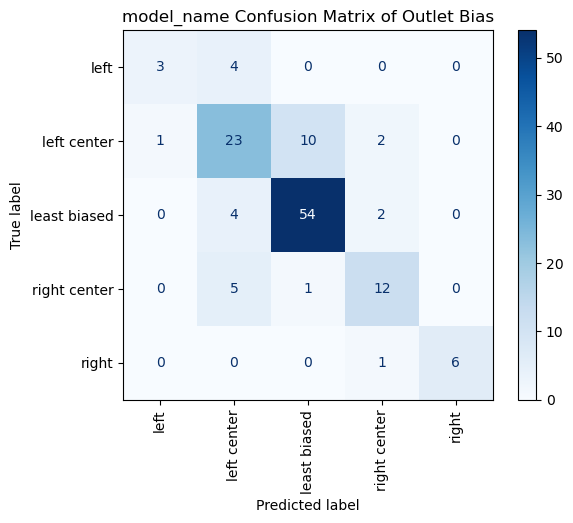

In [10]:
eval_model(model, model_name="PyTorch_Eval", save=False)

Evidently, (though there are few examples) the model has good accuracy for the class right, least biased, and right-center. Classes left and left center are a bit less accurate.

In [11]:
# get true and predicted values (note that y_true here is still prob values per class, not output class)
y_true, y_pred, indexes = predict(model, tabular_data_module)
# get final output from model as single number
y_pred = np.argmax(y_pred,axis=1)
# make y_true nto pd Series with old index intact
y_test = pd.Series(y_true,index=indexes)


# make df of outlet names, predictions
y_test_pred = pd.Series(y_pred,index=indexes)


predicting...


Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

In [12]:
# get output for all of our data

data_loader = tabular_data_module.train_dataloader()
batch_size = data_loader.batch_size
n_rows = len(tabular_data_module.dataset_train)

y_train = np.zeros(n_rows, dtype=np.float32)
y_train_pred = np.zeros((n_rows,5), dtype=np.float32)
indexes = []
with torch.no_grad():
    idx = 0
    for index, num_batch, cat_batch, label_batch in tqdm(data_loader, desc="Evaluating"):
        # get model output
        y_output = model(num_batch, cat_batch)
        y_prob = y_output.cpu().numpy()
        # map exp function to all outputs
        y_prob = list(map(np.exp,y_prob))

        # add predictions to output arrays
        start_idx = idx
        idx += batch_size
        end_idx = idx
        y_train_pred[start_idx:end_idx] = y_prob
        y_train[start_idx:end_idx] = label_batch.cpu().numpy()
        
        # append indexes
        indexes.extend(index)

        if end_idx == n_rows:
            break

# get final output from model as single number
y_train_pred = np.argmax(y_train_pred,axis=1)

# make df of outlet names, predictions
y_train_pred = pd.Series(y_train_pred,index=indexes)

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

In [13]:

data_loader = tabular_data_module.val_dataloader()
batch_size = data_loader.batch_size
n_rows = len(tabular_data_module.dataset_val)

y_val = np.zeros(n_rows, dtype=np.float32)
y_val_pred = np.zeros((n_rows,5), dtype=np.float32)
indexes = []
with torch.no_grad():
    idx = 0
    for index, num_batch, cat_batch, label_batch in tqdm(data_loader, desc="Evaluating"):
        # get model output
        y_output = model(num_batch, cat_batch)
        y_prob = y_output.cpu().numpy()
        # map exp function to all outputs
        y_prob = list(map(np.exp,y_prob))

        # add predictions to output arrays
        start_idx = idx
        idx += batch_size
        end_idx = idx
        y_val_pred[start_idx:end_idx] = y_prob
        y_val[start_idx:end_idx] = label_batch.cpu().numpy()
        
        # append indexes
        indexes.extend(index)

        if end_idx == n_rows:
            break

# get final output from model as single number
y_val_pred = np.argmax(y_val_pred,axis=1)

# make df of outlet names, predictions
y_val_pred = pd.Series(y_val_pred,index=indexes)

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
# make df with all outputs

all_predictions = pd.concat([y_test_pred, y_val_pred, y_train_pred])
all_predictions.name = 'Prediction'

all_predictions.to_csv(f'results/Experiment{dataset_extension}/pytorch_predictions.csv')

In [15]:
os.getcwd()
dataset_extension

'_mbfc_allbias_extrafeatures'

## LLM Baseline Comparison: GPT4.0 Mini

In [16]:
# redefine this to work for the LLM data
def get_AUC_scores(y_test,y_pred): # slight modificatiton due to series and array mix
    """
    Since we need to use OneHotEncoded values for AUC, we'll do that here separately.
    We also calculate the AUC per class, and also its average. Then put this in
    array and pad it so it fits into the report DataFrame.
    """
    ohe = OneHotEncoder()
    out = ohe.fit_transform(y_test.values.reshape(-1, 1)).toarray()
    y_test_ohe = pd.DataFrame(out, index=y_test.index)
    # get same shape for predictions - note that preds often arrays, not series, so don't need .values
    out = ohe.transform(y_pred.values.reshape(-1, 1)).toarray()
    y_pred_ohe = pd.DataFrame(out, index=y_test.index)
    
    # compute actual scores
    AUC_avg = roc_auc_score(y_test_ohe,y_pred_ohe, multi_class='ovr')
    AUC_per_class = roc_auc_score(y_test_ohe,y_pred_ohe, average=None,multi_class='ovr')
    # add AUC to report DF
    AUC_list = np.append(AUC_per_class,AUC_avg)
    AUC_list = np.append(AUC_list, [0,0]) # add padding so it fits into DF
    
    return AUC_list


Test accuracy
55.47%



(           left  left center  least biased  right center     right  accuracy  \
 precision   0.0     0.562500      0.562500      0.333333  0.714286  0.554688   
 recall      0.0     0.250000      0.900000      0.166667  0.714286  0.554688   
 f1-score    0.0     0.346154      0.692308      0.222222  0.714286  0.554688   
 support     7.0    36.000000     60.000000     18.000000  7.000000  0.554688   
 AUC         0.5     0.586957      0.641176      0.556061  0.848878  0.626614   
 
             macro avg  weighted avg  
 precision    0.434524      0.507812  
 recall       0.406190      0.554688  
 f1-score     0.394994      0.492188  
 support    128.000000    128.000000  
 AUC          0.000000      0.000000  ,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x244b4645490>)

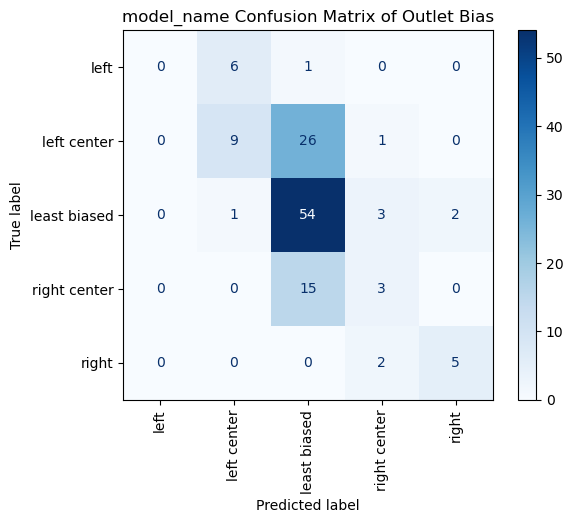

In [17]:
llm_results = {"newsadvance.com": 2, "hometownstations.com": 2,"mycentraljersey.com": 2,"thedailycitizen.com": 2,"kxlh.com": 2,
               "mashable.com": 1,"nbclosangeles.com": 2,"hitc.com": 2,"dglobe.com": 2,"thehill.com": 1,"livemint.com": 2,"kshb.com": 2,
               "coloradopolitics.com": 3,"goerie.com": 2,"digitaljournal.com": 3,"koat.com": 2,"dawn.com": 1,"wwltv.com": 2,"wthr.com": 2,
               "wcnc.com": 2,"rollingstone.com": 1,"thehindubusinessline.com": 2,"walesonline.co.uk": 2,"business2community.com": 2,
               "bridgwatermercury.co.uk": 2,"dispatch.com": 2,"annistonstar.com": 2,"wlky.com": 2,"tucson.com": 2,"thenationalherald.com": 3,
               "aei.org": 4,"ndtv.com": 1,"koreaherald.com": 2,"12news.com": 2,"wral.com": 2,"sbs.com.au": 2,"krtv.com": 2,"kion546.com": 2,
               "wvasfm.org": 2,"stamfordadvocate.com": 2,"wtsp.com": 2,"fox6now.com": 4,"sourcenm.com": 2,"9news.com.au": 2,"crooksandliars.com": 1,
               "americanthinker.com": 4,"fox4news.com": 4,"kens5.com": 2,"abc12.com": 2,"ladysmithchronicle.com": 2,"my9nj.com": 2,
               "dailyprogress.com": 2,"esquire.com": 1,"dl-online.com": 2,"howstuffworks.com": 2,"wdrb.com": 2,"wqad.com": 2,"allafrica.com": 2,
               "globegazette.com": 2,"china.org.cn": 1,"godanriver.com": 2,"bridportnews.co.uk": 2,"inforum.com": 2,"dailyjournal.net": 2,"kob.com": 2,
               "kvoa.com": 2,"investmentwatchblog.com": 4,"brainerddispatch.com": 2,"argusleader.com": 2,"courierpostonline.com": 2,"apr.org": 1,
               "ynetnews.com": 2,"gadsdentimes.com": 2,"ktvh.com": 2,"petoskeynews.com": 2,"brentwoodlive.co.uk": 2,"nola.com": 2,"wsiltv.com": 2,
               "kansasreflector.com": 1,"dailysignal.com": 3,"texastribune.org": 1,"heraldpalladium.com": 2,"afr.com": 3,"wlfi.com": 2,"vladtv.com": 1,
               "kpvi.com": 2,"thenational.scot": 1,"12news.com": 2,"abcactionnews.com": 2,"newscentermaine.com": 2,"gazette.com": 2,"irishtimes.com": 2,
               "kxly.com": 2,"news.cn": 1,"agassizharrisonobserver.com": 2,"wthitv.com": 2,"insideedition.com": 2,"kvia.com": 2,"bicesteradvertiser.net": 2,
               "theconservativetreehouse.com": 4,"sj-r.com": 2,"kezi.com": 2,"business-standard.com": 2,"wtxl.com": 2,"ground.news": 2,"patriotpost.us": 4,
               "breakingdefense.com": 2,"cbsnews.com": 2,"columbiatribune.com": 2,"fox13now.com": 3,"euronews.com": 2,"kvue.com": 2,"wishtv.com": 2,
               "khou.com": 2,"pressofatlanticcity.com": 2,"calgarysun.com": 3,"fox32chicago.com": 3,"israelnationalnews.com": 3,"ktvu.com": 2
              }

llm_df = pd.Series(llm_results).to_frame('LLM_lean').reset_index()
llm_df.columns = ['outlet', 'LLM_lean']
llm_df.set_index("outlet", inplace=True)
# make a df with the LLM scores and the true values
llm_baseline = pd.merge(test['lean'], llm_df, on='outlet')

evaluate_predictions(llm_baseline['lean'], llm_baseline['LLM_lean'], save=False, model_name='GPT4')


In [18]:
# get same but for robertson_all bias

dataset_extension = "_robertson5_allbias"

rob_test = pd.read_csv("data/test{}.csv".format(dataset_extension))
rob_test.set_index("outlet", inplace=True)

#rob_test.index.values


Test accuracy
50.48%



(           left  left center  least biased  right center      right  accuracy  \
 precision   0.0     0.465116      0.502075      0.444444   0.666667  0.504823   
 recall      0.0     0.253165      0.952756      0.063492   0.750000  0.504823   
 f1-score    0.0     0.327869      0.657609      0.111111   0.705882  0.504823   
 support    26.0    79.000000    127.000000     63.000000  16.000000  0.504823   
 AUC         0.5     0.577013      0.650291      0.521665   0.864831  0.622760   
 
             macro avg  weighted avg  
 precision    0.415660      0.447506  
 recall       0.403883      0.504823  
 f1-score     0.360494      0.410650  
 support    311.000000    311.000000  
 AUC          0.000000      0.000000  ,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x244b4a946d0>)

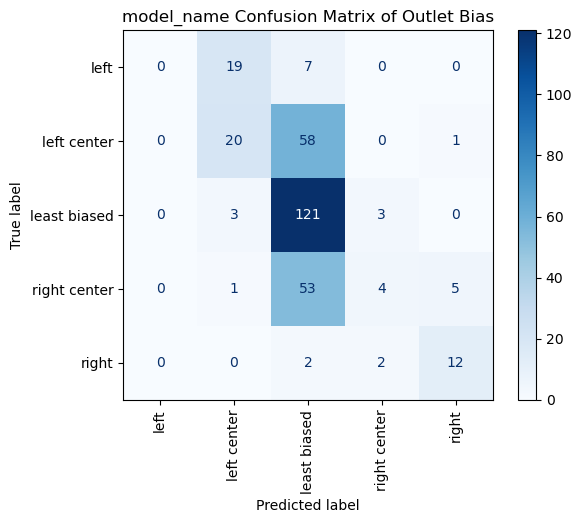

In [19]:
robertson_llm_results = {
    "ibtimes.co.uk": 2,"nocamels.com": 2,"wfmz.com": 2,"bristolpost.co.uk": 1,"krem.com": 2,"en.kremlin.ru": 4,"sputniknews.com": 4,
    "niemanlab.org": 2,"sunjournal.com": 2,"americasquarterly.org": 2,"mid-day.com": 2,"wdel.com": 2,"citybeat.com": 1,"feedstuffs.com": 2,
    "bondbuyer.com": 2,"cpj.org": 2,"auburnpub.com": 2,"state.gov": 2,"mlbtraderumors.com": 2,"yardbarker.com": 2,"starherald.com": 2,
    "recorder.com": 2,"scmp.com": 2,"wkyc.com": 2,"whyy.org": 1,"townhall.com": 4,"gaytimes.co.uk": 1,"lgbtqnation.com": 1,"politico.com": 2,
    "loudountimes.com": 2,"duluthnewstribune.com": 2,"standardmedia.co.ke": 2,"claimsjournal.com": 2,"theskanner.com": 1,"finanznachrichten.de": 2,
    "westfaironline.com": 2,"floridapolitics.com": 3,"pocketnow.com": 2,"searchengineland.com": 2,"environmentalleader.com": 2,"firstshowing.net": 2,
    "taipeitimes.com": 2,"abajournal.com": 2,"sfist.com": 1,"centralmaine.com": 2,"1079ishot.com": 2,"abc15.com": 2,"fox26houston.com": 3,"theverge.com": 2,
    "hbook.com": 2,"mvtimes.com": 2,"heraldtribune.com": 2,"bwog.com": 1,"empireonline.com": 2,"statepress.com": 1,"heritage.org": 4,"cincinnati.com": 2,
    "nbcdfw.com": 2,"theislandnow.com": 2,"helpnetsecurity.com": 2,"iflscience.com": 2,"theguardian.com": 1,"ilo.org": 2,"politicususa.com": 1,"neonnettle.com": 4,
    "sentinelsource.com": 2,"columbiamissourian.com": 2,"seattlepi.com": 2,"spiked-online.com": 3,"oregonbusiness.com": 2,"ebony.com": 1,"torontolife.com": 2,
    "blabbermouth.net": 2,"juxtapoz.com": 2,"rimonthly.com": 2,"tribdem.com": 2,"yourobserver.com": 2,"bakersfield.com": 2,"kvia.com": 2,"ny1.com": 2,"kcra.com": 2,
    "globes.co.il": 2,"crowdfundinsider.com": 2,"wfmj.com": 2,"theadvertiser.com": 2,"wbur.org": 1,"autonews.com": 2,"kitv.com": 2,"kut.org": 2,"prevention.com": 2,
    "kare11.com": 2,"elledecor.com": 2,"qz.com": 2,"asahi.com": 2,"archpaper.com": 2,"thetimes-tribune.com": 2,"digitaljournal.com": 2,"ucsusa.org": 1,"computerworld.com": 2,
    "extremetech.com": 2,"neworleanscitybusiness.com": 2,"chroniclelive.co.uk": 2,"techradar.com": 2,"esquire.com": 1,"wtop.com": 2,"gpb.org": 2,"github.com": 2,
    "brooklyneagle.com": 2,"biblestudytools.com": 3,"personalliberty.com": 4,"washingtonpost.com": 1,"pinkbike.com": 2,"socialmediatoday.com": 2,"bostonmagazine.com": 1,
    "thehollywoodgossip.com": 2,"noozhawk.com": 2,"bearingarms.com": 4,"insidehighered.com": 2,"vaildaily.com": 2,"japantimes.co.jp": 2,"tuscaloosanews.com": 2,
    "infoworld.com": 2,"indystar.com": 2,"lasvegassun.com": 2,"pocket-lint.com": 2,"caranddriver.com": 2,"nmpoliticalreport.com": 1,"thestar.com.my": 2,
    "floridatoday.com": 2,"13newsnow.com": 2,"bonappetit.com": 2,"fox6now.com": 3,"redstate.com": 4,"attackofthefanboy.com": 2,"creativebloq.com": 2,
    "delawareonline.com": 2,"courant.com": 2,"snopes.com": 2,"njherald.com": 2,"theamericanconservative.com": 4,"harvard.edu": 2,"allafrica.com": 2,
    "bloodyelbow.com": 1,"kgun9.com": 2,"bevnet.com": 2,"financial-planning.com": 2,"allaccess.com": 2,"dovepress.com": 2,"ibtimes.com": 2,"fastcompany.com": 2,
    "kgw.com": 2,"times-news.com": 2,"nbcconnecticut.com": 2,"hitconsultant.net": 2,"thenewsenterprise.com": 2,"miami.edu": 2,"fooddive.com": 2,
    "news-journalonline.com": 2,"nationalenquirer.com": 4,"womensagenda.com.au": 1,"manchestereveningnews.co.uk": 2,"designnews.com": 2,
    "nationalmortgagenews.com": 2,"jewishinsider.com": 2,"capitalfm.co.ke": 2,"catholicphilly.com": 2,"lubbockonline.com": 2,"td.org": 2,
    "independentsentinel.com": 4,"kevinmd.com": 2,"usatoday.com": 2,"stamfordadvocate.com": 2,"vladtv.com": 4,
    "thelocal.fr": 2,"perezhilton.com": 2,"theatermania.com": 2,"fosters.com": 2,"chemistryworld.com": 2,"thedailystar.net": 2,"norfolkdailynews.com": 2,
    "comicbookmovie.com": 2,"livemint.com": 2,"wilmingtonbiz.com": 2,"today.com": 2,"meforum.org": 4,"factcheck.org": 2,"thejournal.com": 2,"dslreports.com": 2,
    "nwfdailynews.com": 2,"scrubsmag.com": 2,"mondoweiss.net": 1,"burlingtonfreepress.com": 2,"digg.com": 2,"thelocal.es": 2,"wbir.com": 2,"salemnews.com": 2,
    "teslarati.com": 2,"theamericanscholar.org": 2,"thefutoncritic.com": 2,"9news.com": 2,"therepublic.com": 3,"letsrun.com": 2,"capitalpress.com": 3,
    "wiley.com": 2,"civileats.com": 1,"phandroid.com": 2,"roadandtrack.com": 2,"dealbreaker.com": 2,"cointelegraph.com": 2,"irishmirror.ie": 2,"allkpop.com": 2,
    "rawstory.com": 1,"wmur.com": 2,"postbulletin.com": 2,"christianpost.com": 3,"whitehouse.gov": 2,"joe.co.uk": 2,"orionmagazine.org": 1,"cbc.ca": 2,
    "frieze.com": 2,"nbcboston.com": 2,"wvpublic.org": 2,"retaildive.com": 2,"krwg.org": 2,"numbersusa.com": 4,"vtdigger.org": 1,"newsbusters.org": 4,
    "wesh.com": 2,"cosmopolitan.com": 1,"delmarvanow.com": 2,"nymag.com": 1,"registerguard.com": 2,"takimag.com": 4,"wcfcourier.com": 2,"spectrumlocalnews.com": 2,
    "chicagobusiness.com": 2,"petapixel.com": 2,"bdtonline.com": 2,"rapidcityjournal.com": 2,"arabnews.com": 2,"wccbcharlotte.com": 2,"thelancet.com": 2,
    "nashvillescene.com": 2,"crisismagazine.com": 3,"argusleader.com": 2,"marca.com": 2,"autoweek.com": 2,"ksl.com": 2,"nbcphiladelphia.com": 2,"theledger.com": 2,
    "dazeddigital.com": 1,"seattlemet.com": 1,"tucsonsentinel.com": 1,"haaretz.com": 1,"opensecrets.org": 1,"eater.com": 2,"washingtonian.com": 1,"fodors.com": 2,
    "cmswire.com": 2,"lithub.com": 1,"androidheadlines.com": 2,"redandblack.com": 1,"firerescue1.com": 2,"resilience.org": 1,"theworldlink.com": 2,"ktvq.com": 2,"thehorse.com": 2,
    "winnipegfreepress.com": 2,"dwell.com": 2,"hpcwire.com": 2,"modernfarmer.com": 2,"alternet.org": 1,"bfi.org.uk": 2,"stuff.co.nz": 2,"foodista.com": 2,
    "latinorebels.com": 1,"news.com.au": 2,"modernhealthcare.com": 2,"meadvilletribune.com": 2,"datacenterdynamics.com": 2,"ritholtz.com": 2,"csindy.com": 1,
    "nationofchange.org": 1,"fastcasual.com": 2,"orlandosentinel.com": 2,"huffingtonpost.co.uk": 1,"ny.gov": 2,"mynorthwest.com": 2,"webpronews.com": 2,
    "billoreilly.com": 4,"indiawest.com": 2,"japantoday.com": 2,"thebulletin.org": 2,"mysanantonio.com": 2,"riverfronttimes.com": 1,"americanmilitarynews.com": 4,
    "bleedingcool.com": 2,"houstoniamag.com": 2,"thetowntalk.com": 2,"amestrib.com": 2,"jsonline.com": 2,"gloucestertimes.com": 2,"theeastafrican.co.ke": 2,
    "advocate.com": 1,"edmontonjournal.com": 2,"powwows.com": 2,"enstarz.com": 2,"cpbj.com": 2,"wnyt.com": 2,"tcpalm.com": 2,"darkreading.com": 2
}

llm_df = pd.Series(robertson_llm_results).to_frame('LLM_lean').reset_index()
llm_df.columns = ['outlet', 'LLM_lean']
llm_df.set_index("outlet", inplace=True)
# make a df with the LLM scores and the true values
llm_baseline_robertson = pd.merge(rob_test['lean'], llm_df, on='outlet')

evaluate_predictions(llm_baseline_robertson['lean'], llm_baseline_robertson['LLM_lean'], save=False, model_name='GPT4')

## LLM Baseline Comparison: Llama 3.1

In [20]:
# get outlet names as list
# X_test.index.to_list()


In [21]:
llm_results = {"newsadvance.com": 2, "hometownstations.com": 2, "mycentraljersey.com": 2, "thedailycitizen.com": 2, "kxlh.com": 2, "mashable.com": 1, 
               "nbclosangeles.com": 2, "hitc.com": 2, "dglobe.com": 2, "thehill.com": 2, "livemint.com": 2, "kshb.com": 2, "coloradopolitics.com": 2,
               "goerie.com": 2, "digitaljournal.com": 2, "koat.com": 2, "dawn.com": 2, "wwltv.com": 2, "wthr.com": 2, "wcnc.com": 2, "rollingstone.com": 1, 
               "thehindubusinessline.com": 2, "walesonline.co.uk": 2, "business2community.com": 2, "bridgwatermercury.co.uk": 2, "dispatch.com": 2, 
               "annistonstar.com": 2, "wlky.com": 2, "tucson.com": 2, "thenationalherald.com": 2, "aei.org": 4, "ndtv.com": 2, "koreaherald.com": 2, 
               "12news.com": 2, "wral.com": 2, "sbs.com.au": 2, "krtv.com": 2, "kion546.com": 2, "wvasfm.org": 2, "stamfordadvocate.com": 2, 
               "wtsp.com": 2, "fox6now.com": 2, "sourcenm.com": 2, "9news.com.au": 2, "crooksandliars.com": 0, "americanthinker.com": 4, 
               "fox4news.com": 2, "kens5.com": 2, "abc12.com": 2, "ladysmithchronicle.com": 2, "my9nj.com": 2, "dailyprogress.com": 2, "esquire.com": 1, 
               "dl-online.com": 2, "howstuffworks.com": 2, "wdrb.com": 2, "wqad.com": 2, "allafrica.com": 2, "globegazette.com": 2, "china.org.cn": 2, 
               "godanriver.com": 2, "bridportnews.co.uk": 2, "inforum.com": 2, "dailyjournal.net": 2, "kob.com": 2, "kvoa.com": 2, "investmentwatchblog.com": 4, 
               "brainerddispatch.com": 2, "argusleader.com": 2, "courierpostonline.com": 2, "apr.org": 2, "ynetnews.com": 2, "gadsdentimes.com": 2, 
               "ktvh.com": 2, "petoskeynews.com": 2, "brentwoodlive.co.uk": 2, "nola.com": 2, "wsiltv.com": 2, "kansasreflector.com": 2, "dailysignal.com": 4, 
               "texastribune.org": 2, "heraldpalladium.com": 2, "afr.com": 2, "wlfi.com": 2, "vladtv.com": 2, "kpvi.com": 2, "thenational.scot": 2, 
               "abcactionnews.com": 2, "newscentermaine.com": 2, "gazette.com": 2, "irishtimes.com": 2, "kxly.com": 2, "news.cn": 2, 
               "agassizharrisonobserver.com": 2, "wthitv.com": 2, "insideedition.com": 2, "kvia.com": 2, "bicesteradvertiser.net": 2, 
               "theconservativetreehouse.com": 4, "sj-r.com": 2, "kezi.com": 2, "business-standard.com": 2, "wtxl.com": 2, "ground.news": 2,
               "patriotpost.us": 4, "breakingdefense.com": 2, "cbsnews.com": 2, "columbiatribune.com": 2, "fox13now.com": 2, "euronews.com": 2, 
               "kvue.com": 2, "wishtv.com": 2, "khou.com": 2, "pressofatlanticcity.com": 2, "calgarysun.com": 3, "fox32chicago.com": 3, 
               "israelnationalnews.com": 3, "ktvu.com": 2
              }

llm_df = pd.Series(llm_results).to_frame('LLM_lean').reset_index()
llm_df.columns = ['outlet', 'LLM_lean']
llm_df.set_index("outlet", inplace=True)
# make a df with the LLM scores and the true values
llm_baseline = pd.merge(test['lean'], llm_df, on='outlet')

Test accuracy
53.12%



(               left  left center  least biased  right center     right  \
 precision  1.000000     0.000000      0.513043      0.666667  1.000000   
 recall     0.142857     0.000000      0.983333      0.111111  0.857143   
 f1-score   0.250000     0.000000      0.674286      0.190476  0.923077   
 support    7.000000    36.000000     60.000000     18.000000  7.000000   
 AUC        0.571429     0.483696      0.579902      0.551010  0.928571   
 
            accuracy   macro avg  weighted avg  
 precision  0.531250    0.635942      0.443614  
 recall     0.531250    0.418889      0.531250  
 f1-score   0.531250    0.407568      0.407010  
 support    0.531250  128.000000    128.000000  
 AUC        0.622922    0.000000      0.000000  ,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x24489998250>)

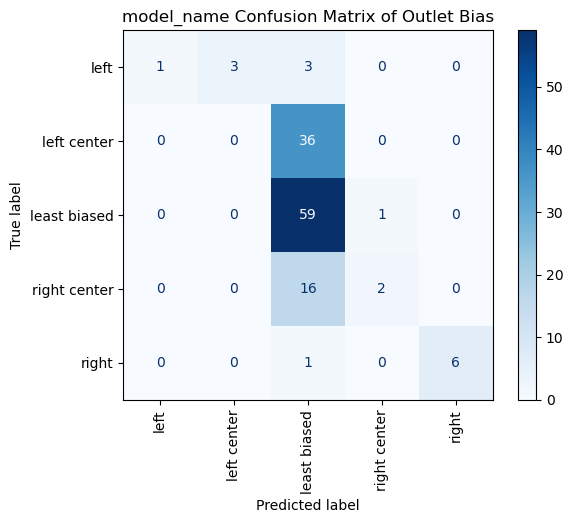

In [22]:
evaluate_predictions(llm_baseline['lean'], llm_baseline['LLM_lean'], save=False, model_name='Llama_3.1')


In [23]:
# get same but for robertson_all bias

dataset_extension = "_robertson5_allbias"

rob_test = pd.read_csv("data/test{}.csv".format(dataset_extension))
rob_test.set_index("outlet", inplace=True)

robertson_llm_results = {
    "ibtimes.co.uk": 2, "nocamels.com": 2, "wfmz.com": 2, "bristolpost.co.uk": 2, "krem.com": 2, "en.kremlin.ru": 4, "sputniknews.com": 4, 
    "niemanlab.org": 2, "sunjournal.com": 2, "americasquarterly.org": 2, "mid-day.com": 2, "wdel.com": 2, "citybeat.com": 2, "feedstuffs.com": 2, 
    "bondbuyer.com": 2, "cpj.org": 2, "auburnpub.com": 2, "state.gov": 2, "mlbtraderumors.com": 2, "yardbarker.com": 2, "starherald.com": 2, 
    "recorder.com": 2, "scmp.com": 2, "wkyc.com": 2, "whyy.org": 2, "townhall.com": 4, "gaytimes.co.uk": 1, "lgbtqnation.com": 1, "politico.com": 2, 
    "loudountimes.com": 2, "duluthnewstribune.com": 2, "standardmedia.co.ke": 2, "claimsjournal.com": 2, "theskanner.com": 2, "finanznachrichten.de": 2, 
    "westfaironline.com": 2, "floridapolitics.com": 2, "pocketnow.com": 2, "searchengineland.com": 2, "environmentalleader.com": 2, "firstshowing.net": 2, 
    "taipeitimes.com": 2, "abajournal.com": 2, "sfist.com": 2, "centralmaine.com": 2, "1079ishot.com": 2, "abc15.com": 2, "fox26houston.com": 3, 
    "theverge.com": 2, "hbook.com": 2, "mvtimes.com": 2, "heraldtribune.com": 2, "bwog.com": 2, "empireonline.com": 2, "statepress.com": 2, 
    "heritage.org": 4, "cincinnati.com": 2, "nbcdfw.com": 2, "theislandnow.com": 2, "helpnetsecurity.com": 2, "iflscience.com": 2, "theguardian.com": 1, 
    "ilo.org": 2, "politicususa.com": 0, "neonnettle.com": 4, "sentinelsource.com": 2, "columbiamissourian.com": 2, "seattlepi.com": 2, "spiked-online.com": 3, 
    "oregonbusiness.com": 2, "ebony.com": 1, "torontolife.com": 2, "blabbermouth.net": 2, "juxtapoz.com": 2, "rimonthly.com": 2, "tribdem.com": 2, 
    "yourobserver.com": 2, "bakersfield.com": 2, "kvia.com": 2, "ny1.com": 2, "kcra.com": 2, "globes.co.il": 2, "crowdfundinsider.com": 2, "wfmj.com": 2, 
    "theadvertiser.com": 2, "wbur.org": 2, "autonews.com": 2, "kitv.com": 2, "kut.org": 2, "prevention.com": 2, "kare11.com": 2, "elledecor.com": 2, 
    "qz.com": 2, "asahi.com": 2, "archpaper.com": 2, "thetimes-tribune.com": 2, "digitaljournal.com": 2, "ucsusa.org": 1, "computerworld.com": 2, 
    "extremetech.com": 2, "neworleanscitybusiness.com": 2, "chroniclelive.co.uk": 2, "techradar.com": 2, "esquire.com": 1, "wtop.com": 2, "gpb.org": 2, 
    "github.com": 2, "brooklyneagle.com": 2, "biblestudytools.com": 2, "personalliberty.com": 4, "washingtonpost.com": 1, "pinkbike.com": 2, 
    "socialmediatoday.com": 2, "bostonmagazine.com": 2, "thehollywoodgossip.com": 2, "noozhawk.com": 2, "bearingarms.com": 4, "insidehighered.com": 2, 
    "vaildaily.com": 2, "japantimes.co.jp": 2, "tuscaloosanews.com": 2, "infoworld.com": 2, "indystar.com": 2, "lasvegassun.com": 2, "pocket-lint.com": 2, 
    "caranddriver.com": 2, "nmpoliticalreport.com": 2, "thestar.com.my": 2, "floridatoday.com": 2, "13newsnow.com": 2, "bonappetit.com": 2, 
    "fox6now.com": 2, "redstate.com": 4, "attackofthefanboy.com": 2, "creativebloq.com": 2, "delawareonline.com": 2, "courant.com": 2, "snopes.com": 2, 
    "njherald.com": 2, "theamericanconservative.com": 4, "harvard.edu": 2, "allafrica.com": 2, "bloodyelbow.com": 2, "kgun9.com": 2, "bevnet.com": 2, 
    "financial-planning.com": 2, "allaccess.com": 2, "dovepress.com": 2, "ibtimes.com": 2, "fastcompany.com": 2, "kgw.com": 2, "times-news.com": 2,
    "nbcconnecticut.com": 2, "hitconsultant.net": 2, "thenewsenterprise.com": 2, "miami.edu": 2, "fooddive.com": 2, "news-journalonline.com": 2, 
    "nationalenquirer.com": 2, "womensagenda.com.au": 1, "manchestereveningnews.co.uk": 2, "designnews.com": 2, "nationalmortgagenews.com": 2, 
    "jewishinsider.com": 2, "capitalfm.co.ke": 2, "catholicphilly.com": 2, "lubbockonline.com": 2, "td.org": 2, "independentsentinel.com": 4, 
    "kevinmd.com": 2, "usatoday.com": 2, "stamfordadvocate.com": 2, "vladtv.com": 2, "thelocal.fr": 2, "perezhilton.com": 2, "theatermania.com": 2, 
    "fosters.com": 2, "chemistryworld.com": 2, "thedailystar.net": 2, "norfolkdailynews.com": 2, "comicbookmovie.com": 2, "livemint.com": 2, 
    "wilmingtonbiz.com": 2, "today.com": 2, "meforum.org": 4, "factcheck.org": 2, "thejournal.com": 2, "dslreports.com": 2, "nwfdailynews.com": 2, 
    "scrubsmag.com": 2, "mondoweiss.net": 0, "burlingtonfreepress.com": 2, "digg.com": 2, "thelocal.es": 2, "wbir.com": 2, "salemnews.com": 2, 
    "teslarati.com": 2, "theamericanscholar.org": 2, "thefutoncritic.com": 2, "9news.com": 2, "therepublic.com": 2, "letsrun.com": 2, "capitalpress.com": 2, 
    "wiley.com": 2, "civileats.com": 1, "phandroid.com": 2, "roadandtrack.com": 2, "dealbreaker.com": 2, "cointelegraph.com": 2, "irishmirror.ie": 2, 
    "allkpop.com": 2, "rawstory.com": 0, "wmur.com": 2, "postbulletin.com": 2, "christianpost.com": 3, "whitehouse.gov": 2, "joe.co.uk": 2, 
    "orionmagazine.org": 1, "cbc.ca": 2, "frieze.com": 2, "nbcboston.com": 2, "wvpublic.org": 2, "retaildive.com": 2, "krwg.org": 2, "numbersusa.com": 4, 
    "vtdigger.org": 2, "newsbusters.org": 4, "wesh.com": 2, "cosmopolitan.com": 1, "delmarvanow.com": 2, "nymag.com": 1, "registerguard.com": 2, 
    "takimag.com": 4, "wcfcourier.com": 2, "spectrumlocalnews.com": 2, "chicagobusiness.com": 2, "petapixel.com": 2, "bdtonline.com": 2, 
    "rapidcityjournal.com": 2, "arabnews.com": 2, "wccbcharlotte.com": 2, "thelancet.com": 2, "nashvillescene.com": 2, "crisismagazine.com": 4, 
    "argusleader.com": 2, "marca.com": 2, "autoweek.com": 2, "ksl.com": 2, "nbcphiladelphia.com": 2, "theledger.com": 2, "dazeddigital.com": 1, 
    "seattlemet.com": 2, "tucsonsentinel.com": 2, "haaretz.com": 2, "opensecrets.org": 2, "eater.com": 2, "washingtonian.com": 2, "fodors.com": 2,
    "cmswire.com": 2, "lithub.com": 2, "androidheadlines.com": 2, "redandblack.com": 2, "firerescue1.com": 2, "resilience.org": 1, "theworldlink.com": 2, 
    "ktvq.com": 2, "thehorse.com": 2, "winnipegfreepress.com": 2, "dwell.com": 2, "hpcwire.com": 2, "modernfarmer.com": 2, "alternet.org": 0, 
    "bfi.org.uk": 2, "stuff.co.nz": 2, "foodista.com": 2, "latinorebels.com": 0, "news.com.au": 2, "modernhealthcare.com": 2, "meadvilletribune.com": 2, 
    "datacenterdynamics.com": 2, "ritholtz.com": 2, "csindy.com": 2, "nationofchange.org": 0, "fastcasual.com": 2, "orlandosentinel.com": 2, 
    "huffingtonpost.co.uk": 1, "ny.gov": 2, "mynorthwest.com": 2, "webpronews.com": 2, "billoreilly.com": 4, "indiawest.com": 2, "japantoday.com": 2,
    "thebulletin.org": 2, "mysanantonio.com": 2, "riverfronttimes.com": 2, "americanmilitarynews.com": 4, "bleedingcool.com": 2, "houstoniamag.com": 2, 
    "thetowntalk.com": 2, "amestrib.com": 2, "jsonline.com": 2, "gloucestertimes.com": 2, "theeastafrican.co.ke": 2, "advocate.com": 1, 
    "edmontonjournal.com": 2, "powwows.com": 2, "enstarz.com": 2, "cpbj.com": 2, "wnyt.com": 2, "tcpalm.com": 2, "darkreading.com": 2
}

llm_df = pd.Series(robertson_llm_results).to_frame('LLM_lean').reset_index()
llm_df.columns = ['outlet', 'LLM_lean']
llm_df.set_index("outlet", inplace=True)
# make a df with the LLM scores and the true values
llm_baseline_robertson = pd.merge(rob_test['lean'], llm_df, on='outlet')

Test accuracy
49.52%



(                left  left center  least biased  right center      right  \
 precision   1.000000     0.500000      0.468401      0.333333   0.764706   
 recall      0.230769     0.101266      0.992126      0.015873   0.812500   
 f1-score    0.375000     0.168421      0.636364      0.030303   0.787879   
 support    26.000000    79.000000    127.000000     63.000000  16.000000   
 AUC         0.615385     0.533392      0.607476      0.503904   0.899470   
 
            accuracy   macro avg  weighted avg  
 precision  0.495177    0.613288      0.508753  
 recall     0.495177    0.430507      0.495177  
 f1-score   0.495177    0.399593      0.380671  
 support    0.495177  311.000000    311.000000  
 AUC        0.631925    0.000000      0.000000  ,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x244b5fce910>)

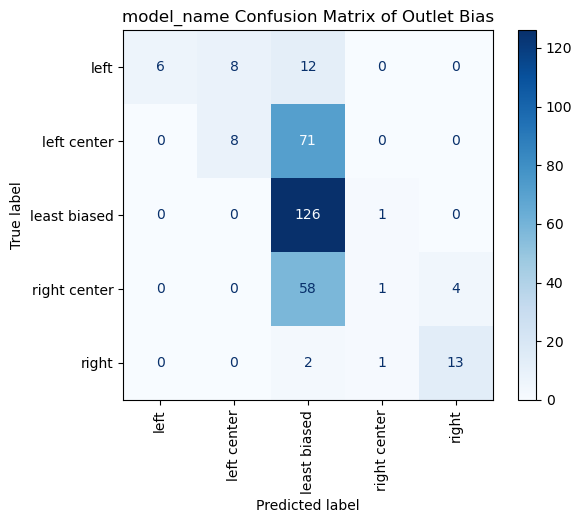

In [24]:
evaluate_predictions(llm_baseline_robertson['lean'], llm_baseline_robertson['LLM_lean'], save=False, model_name='Llama_3.1')

## Examples and Error Analysis

In [25]:
df = test.copy()
df['predicted'] = y_pred

#### Get table of example predictions

In [26]:
example_table = pd.DataFrame({'Index': X_test.index, 'Ground Truth': y_test, 'Prediction': y_pred})
example_table = example_table.drop('Index', axis=1)

In [27]:
# let's replace numbers with leanings
replace_dict = {0:'left', 1: 'left-leaning', 2: 'least biased', 3: 'right-leaning', 4: 'right'}

table = example_table.replace(replace_dict)
table.sample(10)

,Ground Truth,Prediction
kpvi.com,least biased,least biased
columbiatribune.com,left-leaning,least biased
wtxl.com,least biased,least biased
courierpostonline.com,left-leaning,left-leaning
business-standard.com,right-leaning,right-leaning
12news.com,least biased,least biased
patriotpost.us,right,right
newsadvance.com,least biased,least biased
kob.com,least biased,least biased
wsiltv.com,least biased,least biased


In [28]:

# Create a new column 'error' to track incorrect predictions
df['error'] = df['lean'] != df['predicted']

# Group by 'Type' and calculate the error rate for each group
error_rates = df.groupby('lean')['error'].mean().reset_index()
error_rates['lean'] = error_rates['lean'].map(replace_dict)

# get counts per media type
lean_counts = df['lean'].map(replace_dict).value_counts().reset_index()
lean_counts.columns = ['lean', 'Count']

# Merge the counts with the error rates
error_rates_with_counts = pd.merge(error_rates, lean_counts, on='lean')

error_rates_with_counts.sort_values(by='error', ascending=True)

,lean,error,Count
2,least biased,0.100000,60
4,right,0.142857,7
3,right-leaning,0.333333,18
1,left-leaning,0.361111,36
0,left,0.571429,7


### Error rates per Media Type

In [29]:
import seaborn as sns

In [30]:
# Define the dictionary to replace media type numbers with text
media_type_dict = {1: 'Magazine', 2: 'News Agency', 3: 'News Paper', 
                   4: 'Organization/Foundation', 5: 'Radio Station', 6: 'TV Station', 7: 'Website'}

# Create a new column 'error' to track incorrect predictions
df['error'] = df['lean'] != df['predicted']

# Group by 'Type' and calculate the error rate for each group
error_rates = df.groupby('MediaType')['error'].mean().reset_index()
error_rates['MediaType'] = error_rates['MediaType'].map(media_type_dict)

# get counts per media type
media_type_counts = df['MediaType'].map(media_type_dict).value_counts().reset_index()
media_type_counts.columns = ['MediaType', 'Count']

# Merge the counts with the error rates
error_rates_with_counts = pd.merge(error_rates, media_type_counts, on='MediaType')

error_rates_with_counts.sort_values(by='error', ascending=True)

,MediaType,error,Count
4,Radio Station,0.000000,4
5,TV Station,0.132075,53
2,News Paper,0.244444,45
6,Website,0.388889,18
3,Organization/Foundation,0.500000,4
0,Magazine,0.666667,3
1,News Agency,1.000000,1


#### Partial Dependence Plot

##### Required functions

In [31]:
def predict_for_PDP(tabular_model, tabular_data_module):
    print('predicting...')
    data_loader = tabular_data_module.test_dataloader()
    batch_size = data_loader.batch_size
    n_rows = len(tabular_data_module.dataset_test)
    
    y_true = np.zeros(n_rows, dtype=np.float32)
    y_pred = np.zeros((n_rows,5), dtype=np.float32)
    indexes = []
    
    # Get the feature index for 'MediaType'
    feature_idx = list(tabular_data_module.dataset_test[0].keys()).index('MediaType')
    
    with torch.no_grad():
        idx = 0
        for index, num_batch, cat_batch, label_batch in tqdm(data_loader, desc="Evaluating"):
            # get model output
            y_output = tabular_model(num_batch, cat_batch)
            y_prob = y_output.cpu().numpy()
            # map exp function to all outputs
            y_prob = list(map(np.exp,y_prob))

            # add predictions to output arrays
            start_idx = idx
            idx += batch_size
            end_idx = idx
            y_pred[start_idx:end_idx] = y_prob
            y_true[start_idx:end_idx] = label_batch.cpu().numpy()
            
            # append indexes
            indexes.extend(index)

            if end_idx == n_rows:
                break
    
    # Plot the partial dependence
    plot_partial_dependence(tabular_model, tabular_data_module.dataset_test, y_true, 'MediaType')

    return y_true, y_pred, indexes

def plot_partial_dependence(model, dataset, y_true, feature_name):
    """
    Plot the partial dependence of the model's output on the given feature.
    
    Args:
        model (torch.nn.Module): The PyTorch model.
        dataset (torch.utils.data.Dataset): The dataset.
        y_true (np.ndarray): The ground truth labels.
        feature_name (str): The name of the feature to plot the partial dependence for.
    """
    # Get the feature index
    feature_idx = list(dataset[0].keys()).index(feature_name)
    
    # Encode the labels
    label_encoder = LabelEncoder()
    y_true_encoded = label_encoder.fit_transform(y_true)
    
    # Compute the partial dependence
    unique_feature_values = np.unique(np.array([x[feature_idx] for x in dataset]))
    partial_dependence = []
    for feature_value in unique_feature_values:
        X_test_copy = torch.stack([x for x in dataset if x[feature_idx] == feature_value])
        y_pred = model(X_test_copy[:, :feature_idx], X_test_copy[:, feature_idx+1:]).argmax(dim=1).cpu().numpy()
        partial_dependence.append(np.mean(y_pred == y_true_encoded[np.array([x[feature_idx] for x in dataset]) == feature_value]))
    
    # Plot the partial dependence
    plt.figure(figsize=(10, 6))
    plt.plot(unique_feature_values, partial_dependence)
    plt.xlabel(feature_name)
    plt.ylabel("Probability of Correct Prediction")
    plt.title(f"Partial Dependence Plot for {feature_name}")
    plt.show()


In [32]:
#plot_partial_dependence(model, tabular_data_module.test_dataloader, tabular_data_module.label_col, 'MediaType')

#### Errors per Traffic

In [33]:
# Define the dictionary to replace media type numbers with text
traffic_dict = {0: 'Minimal', 1: 'Medium', 2: 'High'}

# Group by 'Type' and calculate the error rate for each group
error_rates = df.groupby('Traffic')['error'].mean().reset_index()
error_rates['Traffic'] = error_rates['Traffic'].map(traffic_dict)

# get counts per media type
traffic_counts = df['Traffic'].map(traffic_dict).value_counts().reset_index()
traffic_counts.columns = ['Traffic', 'Count']

# Merge the counts with the error rates
error_rates_with_counts = pd.merge(error_rates, traffic_counts, on='Traffic')

error_rates_with_counts.sort_values(by='error', ascending=True)

,Traffic,error,Count
1,Medium,0.169231,65
0,Minimal,0.178571,28
2,High,0.400000,35


In [34]:
error_rates = df.groupby('PressFreedom')['error'].mean().reset_index()
error_rates['PressFreedom'] = error_rates['PressFreedom'].map(traffic_dict)

# get counts per media type
press_counts = df['PressFreedom'].map(traffic_dict).value_counts().reset_index()
press_counts.columns = ['PressFreedom', 'Count']

# Merge the counts with the error rates
error_rates_with_counts = pd.merge(error_rates, press_counts, on='PressFreedom')

error_rates_with_counts.sort_values(by='error', ascending=True)

,PressFreedom,error,Count
2,High,0.225,120
1,Medium,0.400,5
0,Minimal,0.500,2


In [35]:
df

,ACT_YIELD_PosScore,ACT_YIELD_article_count,AID_ECONOMIC_SelfRefDens,AID_ECONOMIC_article_count,ASSASSINATION_SelfRefDens,AVIATION_INCIDENT_article_count,BLACK_MARKET_NegScore,BULLYING_article_count,CEASEFIRE_PosScore,CHARASMATIC_LEADERSHIP_Polarity,...,lean,Factuality,PressFreedom,MediaType,Traffic,Credibility,Longitude,Latutude,predicted,error
outlet,,,,,,,,,,,,,,,,,,,,,
newsadvance.com,0.303399,0.385740,0.057966,0.116965,0.100700,0.312244,0.469584,0.148518,0.159387,0.648837,...,2,4,2,3,1,2,-100.445882,39.783730,2,False
hometownstations.com,0.280548,0.050946,0.104620,0.020597,0.058498,0.318132,0.480231,0.117692,0.143195,0.286602,...,2,4,2,6,0,2,-100.445882,39.783730,2,False
hometownstations.com,0.280548,0.050946,0.104620,0.020597,0.058498,0.318132,0.480231,0.117692,0.143195,0.286602,...,2,4,2,6,1,2,-100.445882,39.783730,2,False
hometownstations.com,0.280548,0.050946,0.104620,0.020597,0.058498,0.318132,0.480231,0.117692,0.143195,0.286602,...,2,4,2,6,0,2,-100.445882,39.783730,2,False
mycentraljersey.com,0.851053,0.303014,0.000000,0.000000,0.372426,0.105120,0.235468,0.105000,0.171300,0.320474,...,1,4,2,3,1,2,-100.445882,39.783730,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pressofatlanticcity.com,0.282257,0.241674,0.045209,0.113992,0.177416,0.167680,0.448999,0.145778,0.171671,0.451295,...,2,4,2,3,1,2,-100.445882,39.783730,2,False
calgarysun.com,0.741766,0.078049,0.175374,0.031555,0.392554,0.108305,0.502321,0.264444,0.171485,0.000000,...,3,3,2,3,2,2,-107.991707,61.066692,3,False
fox32chicago.com,0.333044,0.158892,0.047861,0.071377,0.153207,0.236820,0.399978,0.100602,0.146758,0.351801,...,2,4,2,6,2,2,-100.445882,39.783730,2,False


##### Error Analysis for LLM

In [36]:
# Define the dictionary to replace media type numbers with text
df = test.copy()
df['predicted_LLM'] = llm_baseline['LLM_lean']
# Create a new column 'error' to track incorrect predictions
df['error'] = df['lean'] != df['predicted_LLM']

# get dict to replace numbers
traffic_dict = {0: 'Minimal', 1: 'Medium', 2: 'High'}

# Group by 'Type' and calculate the error rate for each group
error_rates = df.groupby('Traffic')['error'].mean().reset_index()
error_rates['Traffic'] = error_rates['Traffic'].map(traffic_dict)

# get counts per media type
traffic_counts = df['Traffic'].map(traffic_dict).value_counts().reset_index()
traffic_counts.columns = ['Traffic', 'Count']

# Merge the counts with the error rates
error_rates_with_counts = pd.merge(error_rates, traffic_counts, on='Traffic')

error_rates_with_counts.sort_values(by='error', ascending=True)

,Traffic,error,Count
1,Medium,0.307692,65
0,Minimal,0.571429,28
2,High,0.685714,35
